In [1]:
#!pip install pyproj matplotlib


In [2]:
import pyproj
import importlib
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
from camera.camera import Camera, FrameData, GPSPoint
from dataclasses import dataclass
importlib.reload(sys.modules['camera'])
importlib.reload(sys.modules['camera.camera'])


<module 'camera.camera' from 'c:\\Users\\krist\\repos\\naplab-to-nerfstudio\\camera\\camera.py'>

In [3]:
transformer = pyproj.Transformer.from_crs("4326", "32633", always_xy=True) # GPS to UTM33

In [4]:
def convert_to_utm(lat, lon, alt):
    """Convert latitude, longitude, and altitude to UTM coordinates."""
    utm_x, utm_y, utm_z = transformer.transform(lon, lat, alt)
    return utm_x, utm_y, utm_z


In [5]:
def process_gps_data(file_path, verbose=False) -> list[GPSPoint]:
    points = []
    """Process a file to read GPS data and convert it to UTM."""
    with open(file_path, 'r') as file:
        for line in file:
            # Check if line contains 'GPS[0]' and match the coordinate pattern, since GPS[0] and GPS[1] are the same
            if 'GPS[0]' in line:
                match = re.search(r"- ([\d]+) lat: ([\d\.]+) lon: ([\d\.]+) alt: ([\d\.]+)", line)
                if match:
                    timestamp = int(match.group(1))
                    lat = float(match.group(2))
                    lon = float(match.group(3))
                    alt = float(match.group(4))
                    utm_x, utm_y, utm_z = convert_to_utm(lat, lon, alt)
                    if verbose:
                        print(f"Original: timestamp={timestamp} lat={lat}, lon={lon}, alt={alt}")
                        print(f"Converted to UTM: X={utm_x}, Y={utm_y}, Z={utm_z}")
                    points.append(GPSPoint(timestamp, np.array([utm_x, utm_y, utm_z])))
    return points

def process_frame(file_path_left, file_path_right, verbose=False) -> list[FrameData]:
    gps_lefts = process_gps_data(file_path_left, verbose)
    gps_rights = process_gps_data(file_path_right, verbose)
    data = []
    for left, right in zip(gps_lefts, gps_rights):
        data.append(FrameData(left, right))
    return data

In [6]:
def plot_3d(series_list: list[list], labels: list[str], figsize=(5, 5)):
    """Plot 3D coordinates."""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    colorpallet = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for s in series_list:
        x = [data[0] for data in s]
        y = [data[1] for data in s]
        z = [data[2] for data in s]
        ax.plot(x, y, z, marker='.', markersize=0.5, color=colorpallet.pop(0))
        
    plt.legend(labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def plot_2d(series_list: list[list], labels: list[str], figsize=(5, 5)):
    """Plot 2D coordinates."""
    colorpallet = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure(figsize=figsize)
    for s in series_list:
        x = [data[0] for data in s]
        y = [data[1] for data in s]
        plt.plot(x, y, marker='.', markersize=0.5, color=colorpallet.pop(0))
    
    plt.legend(labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D plot of XY coordinates')
    plt.show()


In [7]:
c1_front_60_single = Camera("C1_front60Single", 846.863159, 670.665466, 1208, 1920,  #right cam
                    translation=[
                        1.8162150382995605,
                        0.22106018662452698,
                        1.5156701803207397
                    ], 
                    roll_pitch_yaw=[
                        1.6242992877960205,
                        2.82977557182312,
                        2.152301788330078
                    ])

c7_l2 = Camera("C7_L2", 1187.267212, 632.114624, 1208, 1920, 
            translation=[ # left side cam
                        2.072967767715454,
                        0.9314326643943787,
                        1.173095703125
                    ],
                    roll_pitch_yaw=[ # wrong
                        -1.6490494012832642,
                        2.6054768562316895,
                        -6.683704853057861
                    ])
c5_r1 = Camera("C5_R1", 965.822693, 649.506042, 1208, 1920, translation=[1.933815360069275, -0.9714699983596802, 1.1585912704467773], roll_pitch_yaw=[
            2.778383255004883, -1.005295991897583, -131.37277221679688
          ])

print(c1_front_60_single.get_camera_intrinsics())

{'camera_model': 'OPENCV', 'fl_x': 1662.7687752661222, 'fl_y': 1046.158687771602, 'cx': 846.863159, 'cy': 670.665466, 'w': 1920, 'h': 1208, 'k1': 0, 'k2': 0, 'p1': 0, 'p2': 0}


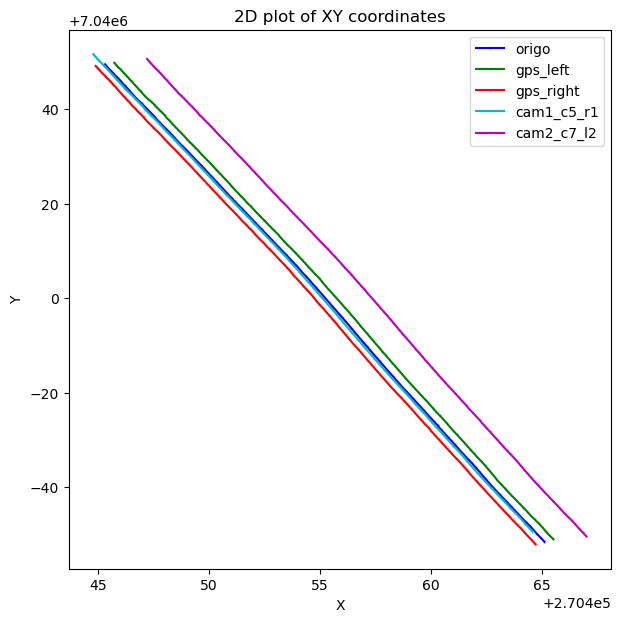

In [14]:

data = process_frame("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt")

gps_left = [frame.left_point for frame in data]
gps_right = [frame.right_point for frame in data]
origo = [frame.center for frame in data]
max_index = 10
cam1_pos = [c5_r1.get_camera_position(frame) for frame in data[:max_index]]
cam2_pos = [c7_l2.get_camera_position(frame) for frame in data[:max_index]]
plot_2d([origo[:max_index], gps_left[:max_index], gps_right[:max_index], cam1_pos, cam2_pos], labels=["origo", "gps_left", "gps_right", "cam1_c5_r1", "cam2_c7_l2"], figsize=(7, 7))



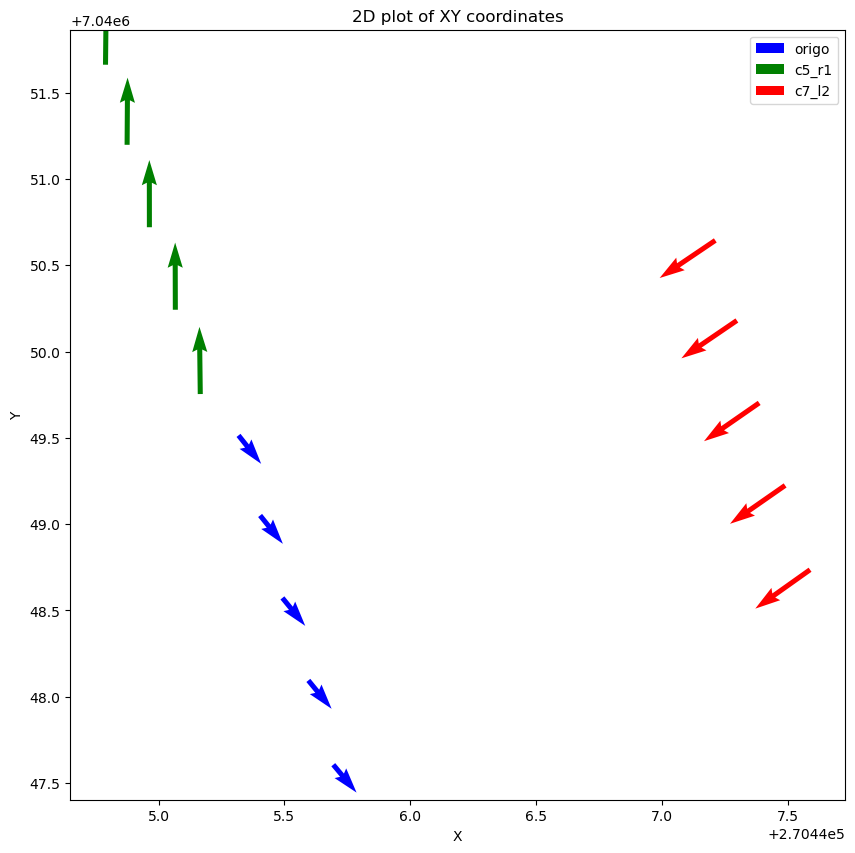

In [10]:
def plot_2d_v2(series_list: list[list], direction_vector_list: list[list], labels: list[str], figsize=(5, 5)):
    """Plot 2D coordinates."""
    colorpallet = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure(figsize=figsize)
    for serie, dirs in zip(series_list, direction_vector_list):
        color = colorpallet.pop(0)
        x = [data[0] for data in serie]
        y = [data[1] for data in serie]
        
        V = np.array(dirs)
        #plt.plot(x, y, marker='.', markersize=0.5, color=color)
        #print(V)
        
        if len(V) > 0:
            plt.quiver(*[x, y], V[:, 0], V[:, 1], color=color, scale=3, units="xy", width=0.025)

    plt.legend(labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D plot of XY coordinates')
    plt.show()
    
max_index = 5
cardir = [frame.direction for frame in data][:max_index]
dir1 = [c5_r1.get_camera_direction_vector(frame) for frame in data][:max_index]
dir2 = [c7_l2.get_camera_direction_vector(frame) for frame in data][:max_index]

directions = [cardir, dir1, dir2]
positions = [origo[:max_index], cam1_pos[:max_index], cam2_pos[:max_index]]
labels = ["origo", "c5_r1", "c7_l2"]
plot_2d_v2(positions, directions, labels, figsize=(10, 10))
